In [15]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
from PIL import Image
from tempfile import TemporaryDirectory
from collections import OrderedDict
from tqdm import tqdm
import datetime

cudnn.benchmark = True
plt.ion()   # interactive mode

In [16]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(644),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(644),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'D:/Data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=32,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [17]:
dataset_sizes

{'train': 4560, 'val': 385}

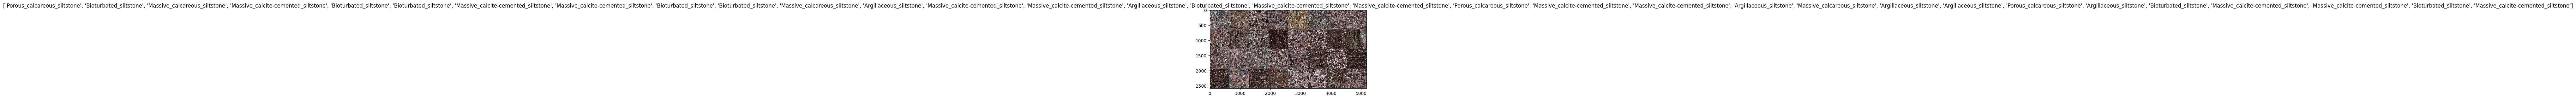

In [18]:
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [19]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0

        for epoch in range(num_epochs):
            print(f'Epoch {epoch}/{num_epochs - 1}')
            print('-' * 10)
            print(datetime.datetime.now())

            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode

                running_loss = 0.0
                running_corrects = 0

                # Iterate over data.
                for inputs, labels in tqdm(dataloaders[phase]):
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                if phase == 'train':
                    scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]

                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

                # deep copy the model
                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)

            print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')

        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path))
    return model

In [20]:
class SKAttention(nn.Module):
    def __init__(self, channel=512, kernels=[1, 3, 5, 7], reduction=16, group=1, L=32):
        super().__init__()
        self.d = max(L, channel // reduction)
        self.convs = nn.ModuleList([])
        for k in kernels:
            self.convs.append(
                nn.Sequential(OrderedDict([
                    ('conv', nn.Conv2d(channel, channel, kernel_size=k, padding=k // 2, groups=group)),
                    ('bn', nn.BatchNorm2d(channel)),
                    ('relu', nn.ReLU())
                ]))
            )
        self.fc = nn.Linear(channel, self.d)
        self.fcs = nn.ModuleList([])
        for i in range(len(kernels)):
            self.fcs.append(nn.Linear(self.d, channel))
        self.softmax = nn.Softmax(dim=0)

    def forward(self, x):
        bs, c, _, _ = x.size()
        conv_outs = []
        ### split
        for conv in self.convs:
            conv_outs.append(conv(x))
        feats = torch.stack(conv_outs, 0)  # k,bs,channel,h,w

        ### fuse
        U = sum(conv_outs)  # bs,c,h,w

        ### reduction channel
        S = U.mean(-1).mean(-1)  # bs,c
        Z = self.fc(S)  # bs,d

        ### calculate attention weight
        weights = []
        for fc in self.fcs:
            weight = fc(Z)
            weights.append(weight.view(bs, c, 1, 1))  # bs,channel
        attention_weughts = torch.stack(weights, 0)  # k,bs,channel,1,1
        attention_weughts = self.softmax(attention_weughts)  # k,bs,channel,1,1

        ### fuse
        V = (attention_weughts * feats).sum(0)
        return V

In [21]:
model_ft = models.mobilenet_v3_large(weights='IMAGENET1K_V2', pretrained=True)
num_ftrs = model_ft.classifier[3].out_features
# Here the size of each output sample is set to 5.
# Alternatively, it can be generalized to ``nn.Linear(num_ftrs, len(class_names))``.
model_ft.fc = nn.Linear(num_ftrs, 5)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
#optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)
optimizer_ft = optim.Adam(model_ft.parameters(), lr=0.0001)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [22]:
model_ft.features

Sequential(
  (0): Conv2dNormActivation(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
    (2): Hardswish()
  )
  (1): InvertedResidual(
    (block): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
        (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
      )
      (1): Conv2dNormActivation(
        (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      )
    )
  )
  (2): InvertedResidual(
    (block): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=0.001, momentum=0.01, affine

In [23]:
model_ft

MobileNetV3(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        )
      )
    )
    (2): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1), bi

In [24]:
#for name, param in model_ft.named_parameters():
#    param.requires_grad = False

In [25]:
#model_ft.features[4].block[2] = SKAttention(channel=72, reduction=8)
#model_ft.features[5].block[2] = SKAttention(channel=120, reduction=8)
#model_ft.features[6].block[2] = SKAttention(channel=120, reduction=8)
#model_ft.features[11].block[2] = SKAttention(channel=480, reduction=8)
#model_ft.features[12].block[2] = SKAttention(channel=672, reduction=8)
#model_ft.features[13].block[2] = SKAttention(channel=672, reduction=8)
model_ft.features[14].block[2] = SKAttention(channel=960, reduction=8)
model_ft.features[15].block[2] = SKAttention(channel=960, reduction=8)

In [26]:
for name, param in model_ft.named_parameters():
    if param.requires_grad:
        print(f"{name} will be updated.")
    else:
        print(f"{name} will not be updated.")

features.0.0.weight will be updated.
features.0.1.weight will be updated.
features.0.1.bias will be updated.
features.1.block.0.0.weight will be updated.
features.1.block.0.1.weight will be updated.
features.1.block.0.1.bias will be updated.
features.1.block.1.0.weight will be updated.
features.1.block.1.1.weight will be updated.
features.1.block.1.1.bias will be updated.
features.2.block.0.0.weight will be updated.
features.2.block.0.1.weight will be updated.
features.2.block.0.1.bias will be updated.
features.2.block.1.0.weight will be updated.
features.2.block.1.1.weight will be updated.
features.2.block.1.1.bias will be updated.
features.2.block.2.0.weight will be updated.
features.2.block.2.1.weight will be updated.
features.2.block.2.1.bias will be updated.
features.3.block.0.0.weight will be updated.
features.3.block.0.1.weight will be updated.
features.3.block.0.1.bias will be updated.
features.3.block.1.0.weight will be updated.
features.3.block.1.1.weight will be updated.
fea

In [27]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=30)

Epoch 0/29
----------
2024-09-07 09:01:58.222646


100%|██████████████████████████████████████████████████████████████████████████████| 143/143 [1:41:21<00:00, 42.53s/it]


train Loss: 0.7841 Acc: 0.7825


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [02:39<00:00, 12.23s/it]


val Loss: 1.1427 Acc: 0.8935

Epoch 1/29
----------
2024-09-07 10:46:03.715536


100%|██████████████████████████████████████████████████████████████████████████████| 143/143 [1:38:40<00:00, 41.40s/it]


train Loss: 0.0897 Acc: 0.9660


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [02:48<00:00, 13.00s/it]


val Loss: 0.2642 Acc: 0.9221

Epoch 2/29
----------
2024-09-07 12:27:38.614568


100%|██████████████████████████████████████████████████████████████████████████████| 143/143 [1:37:35<00:00, 40.95s/it]


train Loss: 0.0392 Acc: 0.9877


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [02:45<00:00, 12.77s/it]


val Loss: 0.4466 Acc: 0.9039

Epoch 3/29
----------
2024-09-07 14:08:00.011495


100%|██████████████████████████████████████████████████████████████████████████████| 143/143 [1:39:29<00:00, 41.74s/it]


train Loss: 0.0210 Acc: 0.9934


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [02:36<00:00, 12.03s/it]


val Loss: 0.1908 Acc: 0.9636

Epoch 4/29
----------
2024-09-07 15:50:10.693077


100%|██████████████████████████████████████████████████████████████████████████████| 143/143 [1:33:44<00:00, 39.33s/it]


train Loss: 0.0146 Acc: 0.9952


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [02:27<00:00, 11.31s/it]


val Loss: 0.2023 Acc: 0.9558

Epoch 5/29
----------
2024-09-07 17:26:21.997109


100%|██████████████████████████████████████████████████████████████████████████████| 143/143 [1:35:17<00:00, 39.98s/it]


train Loss: 0.0110 Acc: 0.9963


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [02:34<00:00, 11.92s/it]


val Loss: 0.3453 Acc: 0.9169

Epoch 6/29
----------
2024-09-07 19:04:14.194111


100%|██████████████████████████████████████████████████████████████████████████████| 143/143 [1:33:26<00:00, 39.21s/it]


train Loss: 0.0078 Acc: 0.9978


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [02:21<00:00, 10.90s/it]


val Loss: 0.2533 Acc: 0.9247

Epoch 7/29
----------
2024-09-07 20:40:02.799126


100%|██████████████████████████████████████████████████████████████████████████████| 143/143 [1:31:47<00:00, 38.52s/it]


train Loss: 0.0039 Acc: 0.9991


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [02:32<00:00, 11.70s/it]


val Loss: 0.1510 Acc: 0.9506

Epoch 8/29
----------
2024-09-07 22:14:22.928432


100%|██████████████████████████████████████████████████████████████████████████████| 143/143 [1:32:51<00:00, 38.96s/it]


train Loss: 0.0018 Acc: 0.9998


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [02:20<00:00, 10.80s/it]


val Loss: 0.1532 Acc: 0.9532

Epoch 9/29
----------
2024-09-07 23:49:34.610275


100%|██████████████████████████████████████████████████████████████████████████████| 143/143 [1:32:18<00:00, 38.73s/it]


train Loss: 0.0016 Acc: 1.0000


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [02:27<00:00, 11.37s/it]


val Loss: 0.1447 Acc: 0.9558

Epoch 10/29
----------
2024-09-08 01:24:21.339876


100%|██████████████████████████████████████████████████████████████████████████████| 143/143 [1:37:53<00:00, 41.07s/it]


train Loss: 0.0016 Acc: 0.9993


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [02:41<00:00, 12.40s/it]


val Loss: 0.1335 Acc: 0.9558

Epoch 11/29
----------
2024-09-08 03:04:56.279689


100%|██████████████████████████████████████████████████████████████████████████████| 143/143 [1:39:55<00:00, 41.92s/it]


train Loss: 0.0013 Acc: 0.9998


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [02:43<00:00, 12.57s/it]


val Loss: 0.1370 Acc: 0.9558

Epoch 12/29
----------
2024-09-08 04:47:34.938458


100%|██████████████████████████████████████████████████████████████████████████████| 143/143 [1:35:11<00:00, 39.94s/it]


train Loss: 0.0018 Acc: 0.9998


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [02:22<00:00, 11.00s/it]


val Loss: 0.1436 Acc: 0.9558

Epoch 13/29
----------
2024-09-08 06:25:09.433297


100%|██████████████████████████████████████████████████████████████████████████████| 143/143 [1:34:44<00:00, 39.75s/it]


train Loss: 0.0008 Acc: 1.0000


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [02:20<00:00, 10.81s/it]


val Loss: 0.1480 Acc: 0.9506

Epoch 14/29
----------
2024-09-08 08:02:14.219927


100%|██████████████████████████████████████████████████████████████████████████████| 143/143 [1:33:00<00:00, 39.03s/it]


train Loss: 0.0011 Acc: 0.9998


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [02:23<00:00, 11.02s/it]


val Loss: 0.1511 Acc: 0.9506

Epoch 15/29
----------
2024-09-08 09:37:38.306630


100%|██████████████████████████████████████████████████████████████████████████████| 143/143 [1:30:49<00:00, 38.11s/it]


train Loss: 0.0010 Acc: 1.0000


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [02:41<00:00, 12.42s/it]


val Loss: 0.1488 Acc: 0.9506

Epoch 16/29
----------
2024-09-08 11:11:09.058658


100%|██████████████████████████████████████████████████████████████████████████████| 143/143 [1:39:48<00:00, 41.88s/it]


train Loss: 0.0011 Acc: 0.9998


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [02:41<00:00, 12.46s/it]


val Loss: 0.1538 Acc: 0.9506

Epoch 17/29
----------
2024-09-08 12:53:39.433918


100%|██████████████████████████████████████████████████████████████████████████████| 143/143 [1:39:25<00:00, 41.71s/it]


train Loss: 0.0014 Acc: 0.9998


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [02:26<00:00, 11.24s/it]


val Loss: 0.1570 Acc: 0.9481

Epoch 18/29
----------
2024-09-08 14:35:30.759071


100%|██████████████████████████████████████████████████████████████████████████████| 143/143 [1:32:22<00:00, 38.76s/it]


train Loss: 0.0013 Acc: 0.9998


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [02:26<00:00, 11.27s/it]


val Loss: 0.1606 Acc: 0.9481

Epoch 19/29
----------
2024-09-08 16:10:19.931588


100%|██████████████████████████████████████████████████████████████████████████████| 143/143 [1:35:09<00:00, 39.93s/it]


train Loss: 0.0011 Acc: 1.0000


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [02:19<00:00, 10.74s/it]


val Loss: 0.1615 Acc: 0.9481

Epoch 20/29
----------
2024-09-08 17:47:49.501271


100%|██████████████████████████████████████████████████████████████████████████████| 143/143 [1:36:11<00:00, 40.36s/it]


train Loss: 0.0007 Acc: 1.0000


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [02:31<00:00, 11.65s/it]


val Loss: 0.1582 Acc: 0.9481

Epoch 21/29
----------
2024-09-08 19:26:31.991668


100%|██████████████████████████████████████████████████████████████████████████████| 143/143 [1:32:06<00:00, 38.64s/it]


train Loss: 0.0010 Acc: 1.0000


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [02:22<00:00, 10.95s/it]


val Loss: 0.1576 Acc: 0.9481

Epoch 22/29
----------
2024-09-08 21:01:00.420454


100%|██████████████████████████████████████████████████████████████████████████████| 143/143 [1:33:39<00:00, 39.30s/it]


train Loss: 0.0009 Acc: 1.0000


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [02:39<00:00, 12.25s/it]


val Loss: 0.1598 Acc: 0.9481

Epoch 23/29
----------
2024-09-08 22:37:18.946628


100%|██████████████████████████████████████████████████████████████████████████████| 143/143 [1:33:49<00:00, 39.37s/it]


train Loss: 0.0008 Acc: 1.0000


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [02:43<00:00, 12.56s/it]


val Loss: 0.1585 Acc: 0.9481

Epoch 24/29
----------
2024-09-09 00:13:52.215480


100%|██████████████████████████████████████████████████████████████████████████████| 143/143 [1:33:22<00:00, 39.18s/it]


train Loss: 0.0011 Acc: 1.0000


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [02:39<00:00, 12.27s/it]


val Loss: 0.1587 Acc: 0.9481

Epoch 25/29
----------
2024-09-09 01:49:54.290866


100%|██████████████████████████████████████████████████████████████████████████████| 143/143 [1:32:14<00:00, 38.71s/it]


train Loss: 0.0009 Acc: 1.0000


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [02:33<00:00, 11.81s/it]


val Loss: 0.1585 Acc: 0.9481

Epoch 26/29
----------
2024-09-09 03:24:42.677391


100%|██████████████████████████████████████████████████████████████████████████████| 143/143 [1:33:28<00:00, 39.22s/it]


train Loss: 0.0024 Acc: 0.9991


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [02:18<00:00, 10.68s/it]


val Loss: 0.1584 Acc: 0.9481

Epoch 27/29
----------
2024-09-09 05:00:29.978334


100%|██████████████████████████████████████████████████████████████████████████████| 143/143 [1:33:58<00:00, 39.43s/it]


train Loss: 0.0014 Acc: 0.9998


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [02:18<00:00, 10.68s/it]


val Loss: 0.1573 Acc: 0.9481

Epoch 28/29
----------
2024-09-09 06:36:47.017482


100%|██████████████████████████████████████████████████████████████████████████████| 143/143 [1:34:38<00:00, 39.71s/it]


train Loss: 0.0008 Acc: 0.9998


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [02:39<00:00, 12.27s/it]


val Loss: 0.1557 Acc: 0.9481

Epoch 29/29
----------
2024-09-09 08:14:05.038219


100%|██████████████████████████████████████████████████████████████████████████████| 143/143 [1:36:21<00:00, 40.43s/it]


train Loss: 0.0011 Acc: 0.9998


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [02:26<00:00, 11.27s/it]


val Loss: 0.1558 Acc: 0.9481

Training complete in 2930m 60s
Best val Acc: 0.963636


In [28]:
test_transforms = {
    'test': transforms.Compose([
        transforms.Resize(644),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}
data_dir = 'D:/Data'
test_ds = {x: datasets.ImageFolder(os.path.join(data_dir, x), test_transforms[x])
                  for x in ['test']}
test_dataloader = {x: torch.utils.data.DataLoader(test_ds[x], batch_size=4,
                                             shuffle=False, num_workers=4) for x in ['test']}

def test_model(model, loss_fn, dataloader):
    # Set the model to evaluation mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.eval()
    size = len(test_ds['test'])
    correct = 0.0

    # Evaluating the model with torch.no_grad() ensures that no gradients are computed during test mode
    # also serves to reduce unnecessary gradient computations and memory usage for tensors with requires_grad=True
    with torch.no_grad():
        for X, y in test_dataloader['test']:
            X= X.to(device)
            outputs = model(X)
            _, preds = torch.max(outputs, 1)
            correct += torch.sum(preds == y.data)

    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%")

test_model(model_ft, criterion, test_dataloader)

Test Error: 
 Accuracy: 96.8%
